# Clustering
We handle clustering ploblem as an optimization problem.

## Overview
Clustering is the classification of a large number of data with different values into a number of clusters.  
By classifying data with similar characteristics into the same cluster, it is possible to group them, which is used for marketing and other purposes.

## Example

### Clustering by QAOA
Consider the case where four points (nodes) are divided into two clusters.  

First we have a pair of qubits set $q_0,q_1,q_2,q_3$ and $q_4,q_5,q_6,q_7$ that represent two clusters.  
$q_0$ and $q_4$, $q_1$ and $q_5$, $q_2$ and $q_6$, $q_3$ and $q_7$ each represent the same node, and the qubit representing the cluster to which the node belongs will have the value 1, while the qubit representing the cluster to which it does not belong will have the value 0. 
For example, if node 0 belongs to cluster 1, then $q_0 = 1, q_4 = 0$, and if node 0 belongs to cluster 2, then $q_0 = 0, q_4 = 1$.  
Therefore, the required number of qubits is $4\times2=8$.

Set the cost function so that the sum of the distances between the nodes in same cluster become small.

$$
Cost = \sum d_{ij} q_i q_j\ \ \ \ (q_i \in \{0, 1\})
$$

$d_{ij}$ is the distance between nodes $i$ and $j$.

The constraint is set so that only one of the qubits representing the same node will be 1 and the rest will be 0.
$$
Constraint = \sum(\sum_{i}^n q_i - 1)^2
$$

However, in QAOA, in this case, the constraint term can be removed by implementing the XY mixer circuit.

The $XY$ mixer performs a time evolution by the following matrix $H_{XY}$.  

$$
H_{XY} = (X_0 X_1 + Y_0 Y_1)/2 = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$

The time evolution is represented by the following two-qubit gate $U_{XY}$.

$$
U_{XY} = e^{-i\theta H_{XY}} = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & \cos\theta & -i\sin\theta & 0 \\
0 & -i\sin\theta & \cos\theta & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$

The amplitude is exchanged between the two states $\lvert 01\rangle$ and $\lvert 10\rangle$.   
Therefore, if we prepare an entanglement of $\lvert 01\rangle$ and $\lvert 10\rangle$ as initial states and apply $U_{XY}$, we can search only between the two states of $\lvert 01\rangle$ and $\lvert 10\rangle$ while keeping the amplitudes of $\lvert 00\rangle$ and $\lvert 11\rangle$, which do not satisfy the constraint conditions, at zero.   
This means that constraints can be removed from QUBO because solutions that do not satisfy the constraints will not be explored.

Thus, the QUBO matrix consists only of the cost function.  
Expressed in a network diagram, we can see that there are fewer edges than when the constraint term was included.  
This means that the problem becomes simpler with fewer interactions.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from blueqat import Circuit
from blueqat.utils import qaoa
from blueqat.pauli import X,Y,Z
from blueqat.pauli import qubo_bit as q

First, we create the data. This time, we will divide the 50 nodes into 2 clusters.

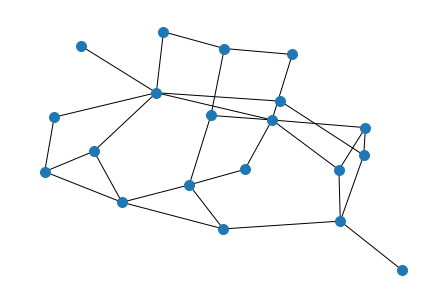

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

n = 20
m = 30
seed = 15

options = {'node_size': 100}

G = nx.gnm_random_graph(n, m, seed = seed)
nx.draw(G, **options)

Next, we will create a QUBO matrix.

First, we prepare a QUBO matrix that represents a cost function based on the connection between nodes.

sample:0111101011100100011110000101000110111000


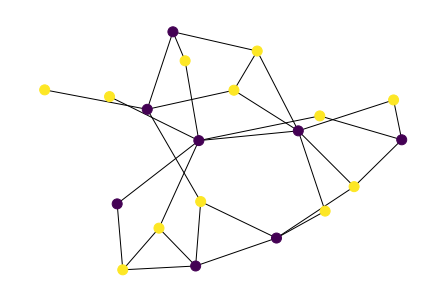

In [7]:
hamiltonian = sum(q(e[0])*q(e[1]) + q(e[0]+n)*q(e[1]+n)  for e in G.edges)
step = 1

#mixer and init state
mixer = 0.0
init = Circuit()
for i in range(n):
    mixer += 0.5*X[i]*X[i+n] + 0.5*Y[i]*Y[i+n]
    init.h[i].cx[i,i+n].x[i]

result = qaoa(hamiltonian, step, init, mixer)
b = result.circuit.run(shots=10)
sample = b.most_common(1)[0][0]
print("sample:"+ str(sample))

nx.draw(G, **options, node_color=[int(s) for s in list(sample[:n])])